In [1]:
# Include sslearn folder
import sys
sys.path.append('../../../sslearn')
from sslearn.wrapper import CoTraining
from sslearn.base import OneVsRestSSLClassifier
import pickle as pkl
import numpy as np
import os
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

In [2]:
results_dir = "results/multiview_experiments_avgfp_RandomForestClassifier"

In [3]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", "ProtVec"]
# Get list of tuples from combinations
labeled_sizes = [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01, 0.005, 0.001]
comb = list(combinations(encodings, 2))

In [4]:
global_auc_dict = dict()

for enc1, enc2 in comb:
    global_auc_dict[f"cotraining-{enc1}-{enc2}"] = dict()
    global_auc_dict[enc1] = dict()
    global_auc_dict[enc2] = dict()
    global_auc_dict["concat-"+enc1+"-"+enc2] = dict()
    global_auc_dict["st-lr-"+enc1+"-"+enc2] = dict()
    global_auc_dict["st-mean-"+enc1+"-"+enc2] = dict()

    for labeled_size in labeled_sizes:
        with open(f'{results_dir}/auc_dict_ct_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_auc_dict[f"cotraining-{enc1}-{enc2}"][labeled_size] = pkl.load(f)[labeled_size]
        with open(f'{results_dir}/auc_dict_{enc1}_{labeled_size}.pickle', 'rb') as f:
            global_auc_dict[enc1][labeled_size] = pkl.load(f)[labeled_size]
        with open(f'{results_dir}/auc_dict_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_auc_dict[enc2][labeled_size] = pkl.load(f)[labeled_size]
        with open(f'{results_dir}/auc_dict_concat_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_auc_dict["concat-"+enc1+"-"+enc2][labeled_size] = pkl.load(f)[labeled_size]
        with open(f'{results_dir}/auc_dict_st_lr_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_auc_dict["st-lr-"+enc1+"-"+enc2][labeled_size] = pkl.load(f)[labeled_size]
        with open(f'{results_dir}/auc_dict_st_mean_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_auc_dict["st-mean-"+enc1+"-"+enc2][labeled_size] = pkl.load(f)[labeled_size]
    
# Create results dataframe
df = pd.DataFrame(columns=['Labeled', 'View', 'AUC'])
for view, labeled_sizes in global_auc_dict.items():
    for labeled_size, aucs in labeled_sizes.items():
        for auc in aucs:
            df = pd.concat([df, pd.DataFrame({'Labeled': labeled_size, 'View': view, 'AUC': auc}, index=[0])], ignore_index=True)

In [5]:
def get_one_vs_all_results(df, encodings, view, views):
    # Read times best from pkl for each results folder (each pair of encodings)
    one_vs_all_dict = dict()

    # Shape of the dictionary pickled is:
    # cotraining_vs_best_dict -> labeled_percentage -> k -> difference from cotraining auc to best

    # Getting mean results from kfold
    comb = combinations(encodings, 2)
    for enc1, enc2 in comb:
        one_vs_all_dict[(enc1, enc2)] = dict()
        for labeled_percentage in df['Labeled'].unique():
            means = dict()
            means["CoTraining"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"cotraining-{enc1}-{enc2}")]['AUC'].mean()
            means["View1"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc1)]['AUC'].mean()
            means["View2"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc2)]['AUC'].mean()
            means["Concat"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"concat-{enc1}-{enc2}")]['AUC'].mean()
            means["Stacking-lr"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-lr-{enc1}-{enc2}")]['AUC'].mean()
            means["Stacking-mean"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-mean-{enc1}-{enc2}")]['AUC'].mean()

            # Get the difference between cotraining and best
            # Get the difference between means[view] and the maximum of the rest of the values of the dictionary
            one_vs_all_dict[(enc1, enc2)][labeled_percentage] = means[view] - max([means[rival] for rival in views if rival != view])
    return one_vs_all_dict

In [6]:
import pandas as pd

def create_heatmap_dict(one_vs_all_dict, labeled, view):

    heatmap_dict = {}

    number_of_experiments = 0
    for encodings, results in one_vs_all_dict.items():
        enc1, enc2 = encodings
        
        heatmap_dict[(enc1, enc2)] = results[labeled]

    ser = pd.Series(list(heatmap_dict.values()),
                    index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
    df = ser.unstack().fillna(0)

    # Set values from (index1, index2) to (index2, index1)
    for index1, index2 in one_vs_all_dict.keys():
        # Create index if it doesn't exist
        if index2 not in df.index:
            df.loc[index2] = 0
        if index1 not in df.columns:
            df[index1] = 0
        df.loc[index2, index1] = df.loc[index1, index2]

    # Sort indexes by name
    df = df.sort_index(axis=0)
    df = df.sort_index(axis=1)

    # Set new column and index order
    new_columns_order = ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', # Binary
                        'Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors', # Physicochemical properties
                        'PAM250', 'BLOSUM62', # Evolution-based
                        'Miyazawa_energies', 'Micheletti_potentials', # Structure-based 
                        'AESNN3', 'ANN4D', 'ProtVec']   # Machine learning-based

    groups_dict = {"Binary": ['One_hot', 'One_hot_6_bit', 'Binary_5_bit'],
                    "Physicochemical": ['Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors'],
                    "Evolution": ['PAM250', 'BLOSUM62'],
                    "Structure": ['Miyazawa_energies', 'Micheletti_potentials'],
                    "Machine learning": ['AESNN3', 'ANN4D', 'ProtVec']}

    new_index_order = new_columns_order
    df = df.reindex(new_index_order, axis=0)
    df = df.reindex(new_columns_order, axis=1)

    # Set heatmap limits to 1 and 0
    # Hide heatmap legend
    sns.heatmap(df, cmap="RdYlGn", center=0, vmin=-0.1, vmax=0.1)
    # Group heatmap columns by group
    for group, encodings in groups_dict.items():
        plt.axvline(x=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.axhline(y=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.text(x=-10, y=new_columns_order.index(encodings[-1])-1, s=group, rotation=0, fontsize=8)
        
    # Set title
    plt.title(f'{view} being best | {labeled*100}% labeled | (∼{int(30000*labeled*0.25)} pos / ∼{int(30000*labeled*0.75)} neg)', fontsize=14)
    plt.show()
    return df

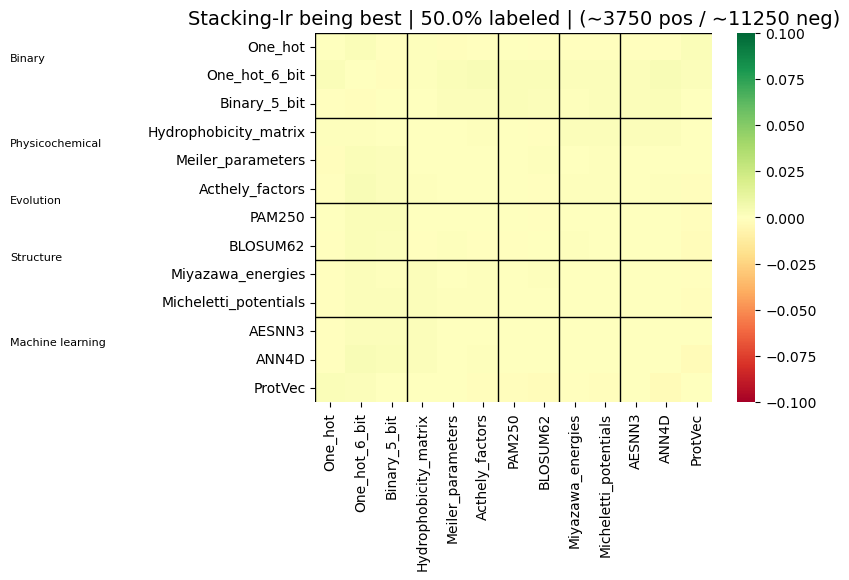

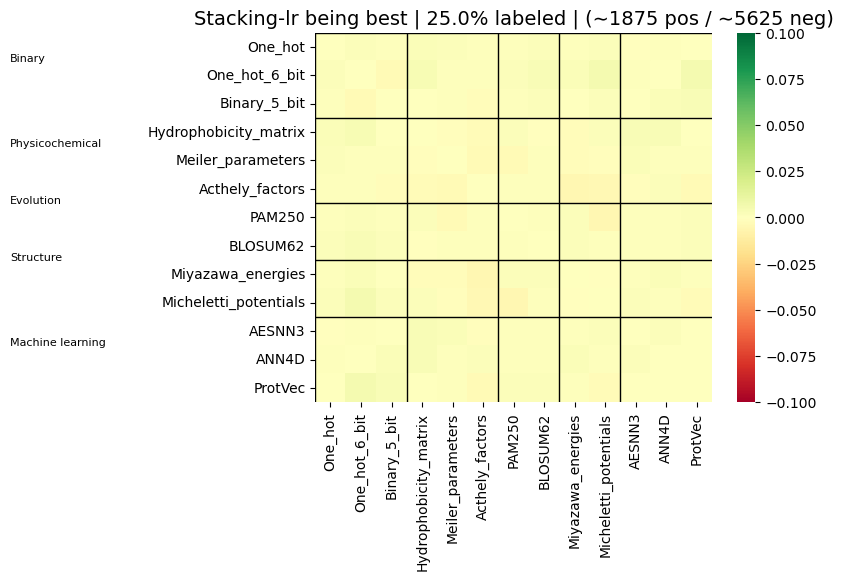

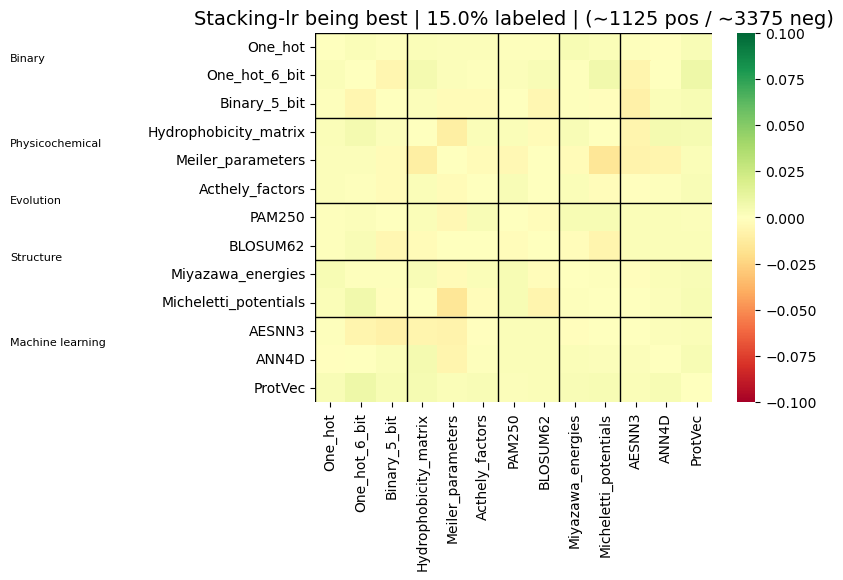

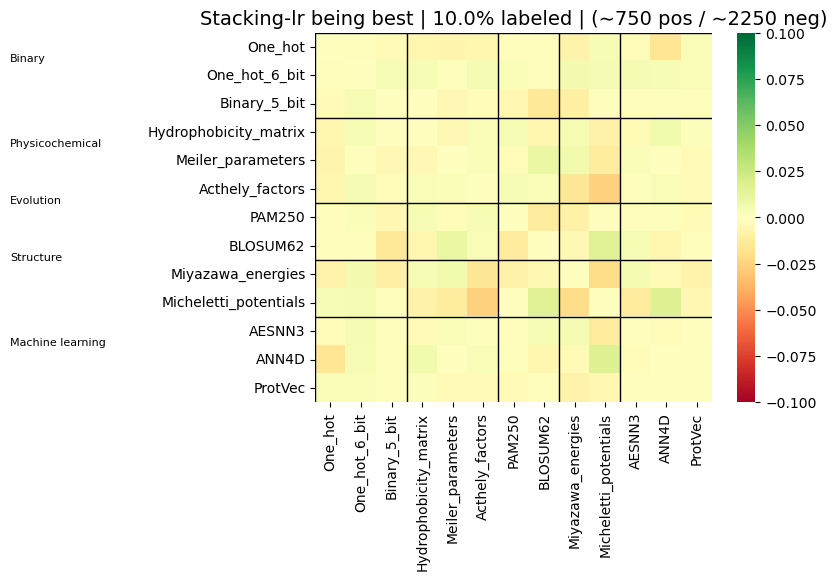

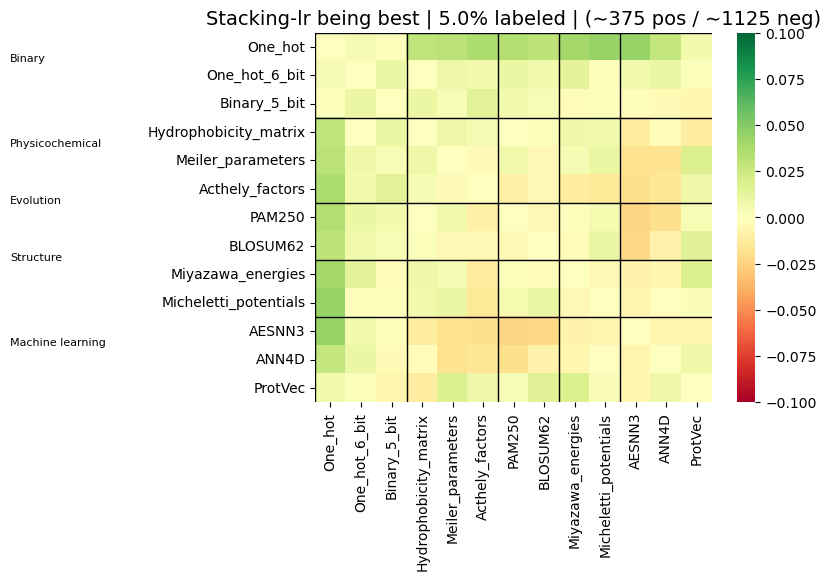

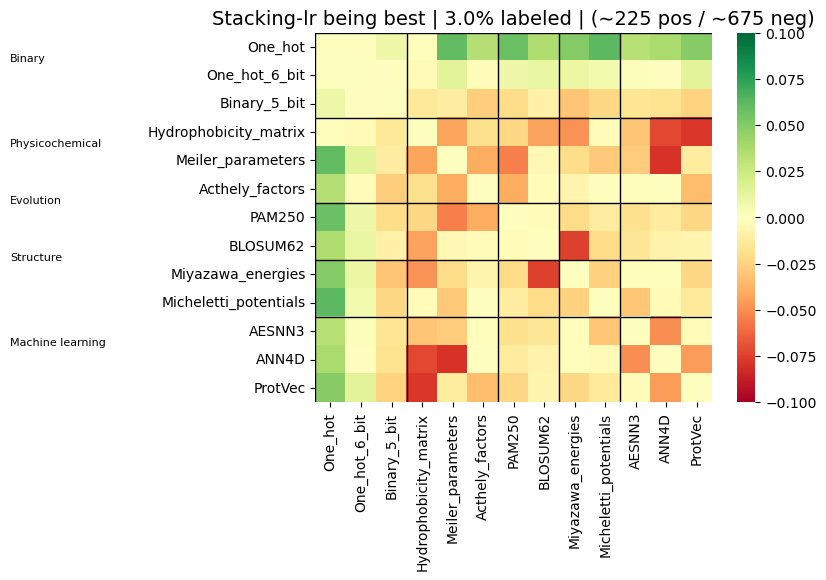

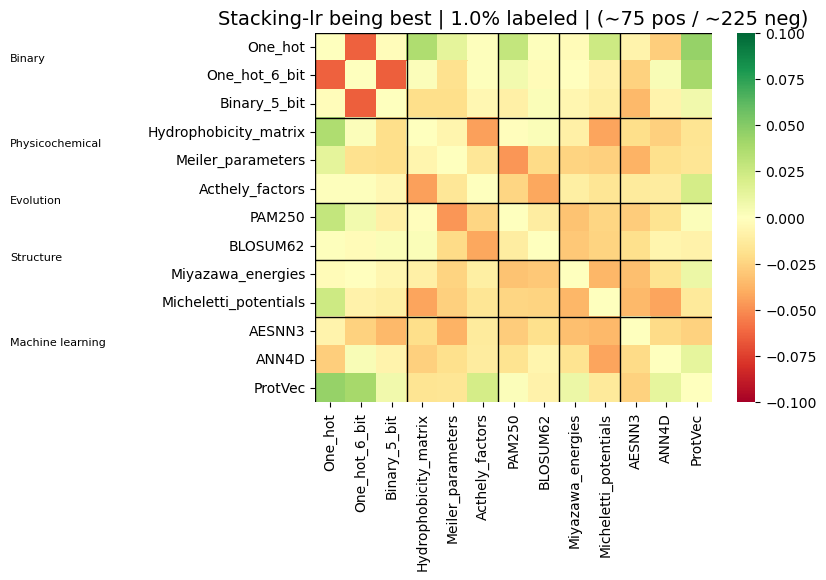

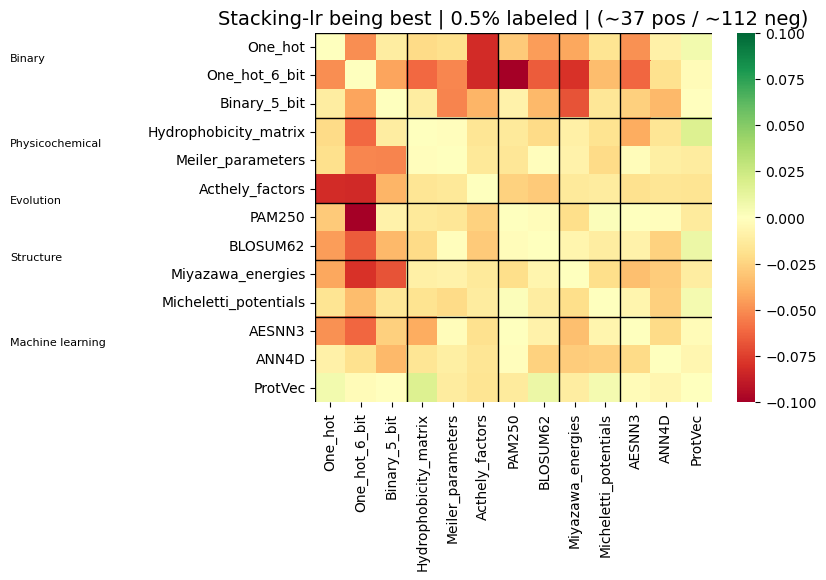

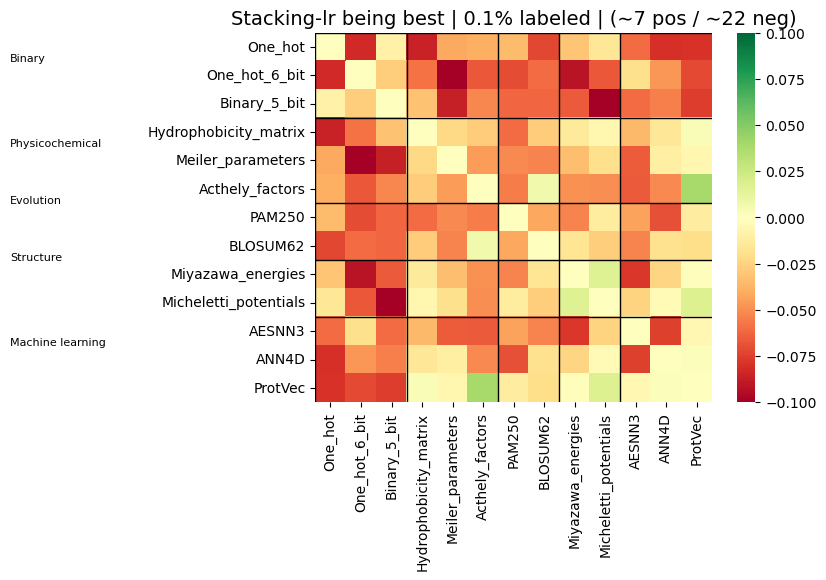

In [8]:
labeled_sizes =  [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01, 0.005, 0.001]
for labeled_size in labeled_sizes:
    view = "Stacking-lr" # CoTraining, Concat, Stacking-lr, Stacking-mean, View1 or View2
    #views =  ["CoTraining", "Concat", "Stacking-lr", "Stacking-mean", "View1", "View2"]
    views =  ["CoTraining", "Concat", "View1", "View2"]
    #views =  ["CoTraining", "Concat", "View1", "View2"]
    one_vs_all_dict = get_one_vs_all_results(df, encodings, view, views) 
    create_heatmap_dict(one_vs_all_dict, labeled_size, view);


# Boxplots for a encoding pair

No handles with labels found to put in legend.


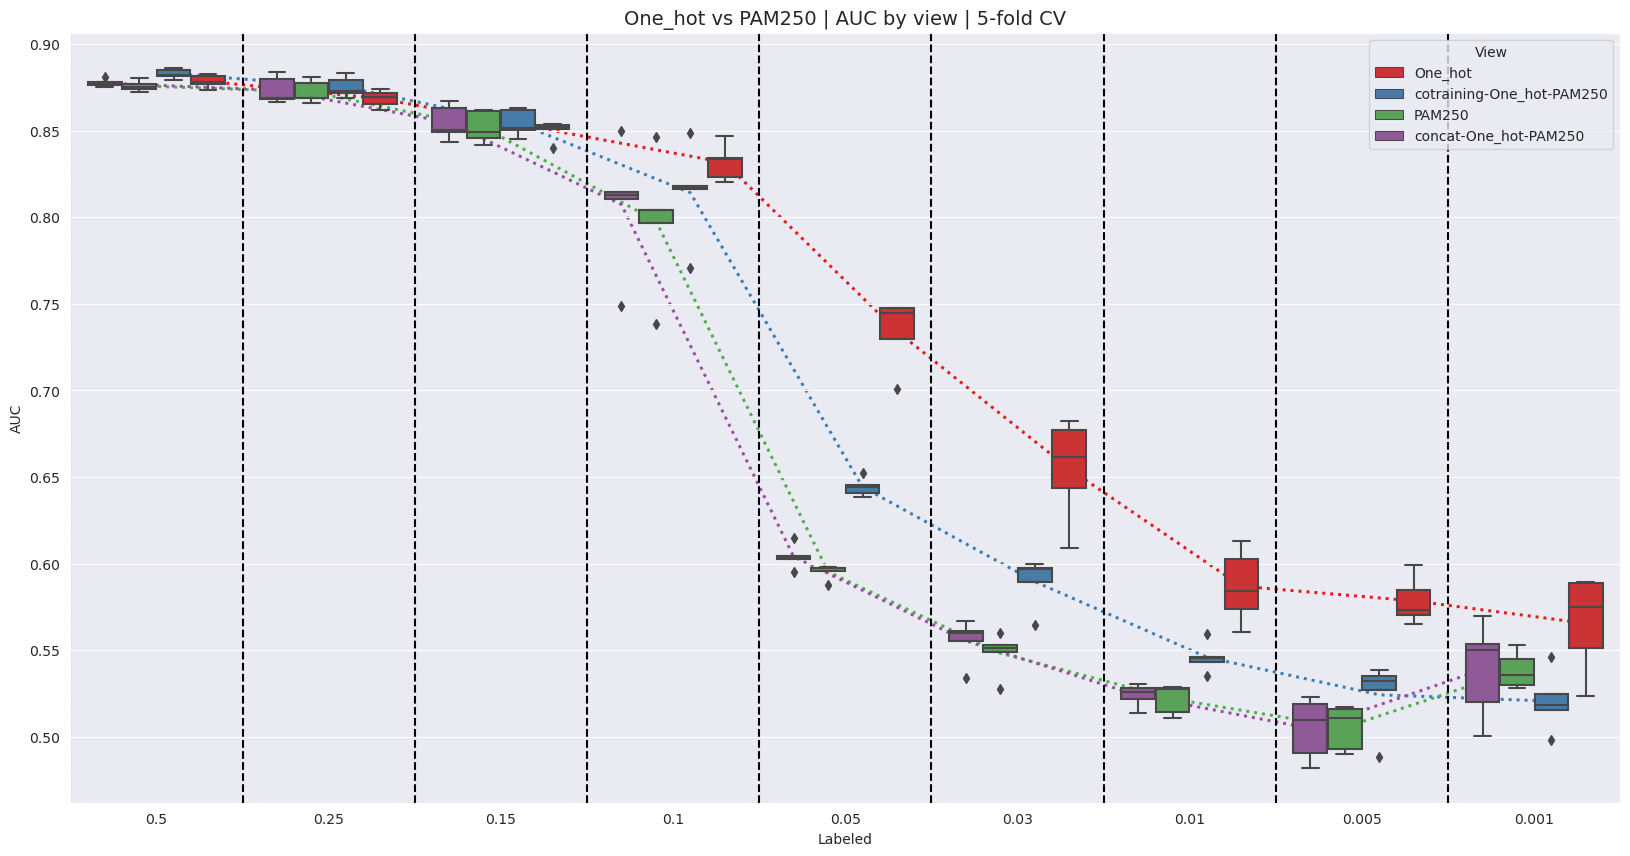

In [8]:
enc1 = 'One_hot'
enc2 = 'PAM250'
#for enc1, enc2 in combinations(encodings, 2):
# Boxplot for folds aucs
plt.figure(figsize=(20, 10))

boxplot_df = df.loc[(df['View'] == f"cotraining-{enc1}-{enc2}") | (df['View'] == enc1) | (df['View'] == enc2) | (df['View'] == f"concat-{enc1}-{enc2}")] #| (df['View'] == f"st-lr-{enc1}-{enc2}") | (df['View'] == f"st-mean-{enc1}-{enc2}")]

#boxplot_df = pd.melt(boxplot_df, ['Labeled'], var_name='View', value_name='AUC')
boxplot_df
# Boxplot grouped by labeled
# Vertical and horizontal grid background
sns.set_style("darkgrid")
# Add underscore at the beginning of every instance in view column in boxplot_df
pointplot_df = boxplot_df.copy()
pointplot_df["View"] = pointplot_df['View'].apply(lambda x: f"_{x}")
ax = sns.pointplot(data=pointplot_df, x='Labeled', y='AUC', 
                    hue='View', ci=None, linestyles=":",
                    dodge=.8-0.8/4, scale=0.8, markers="",
                    palette="Set1")

plt.setp(ax.lines, zorder=0)
sns.boxplot(x="Labeled", y="AUC", hue="View", data=boxplot_df, palette="Set1",)
[plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(labeled_sizes))]
plt.title(f'{enc1} vs {enc2} | AUC by view | 5-fold CV', fontsize=14)
plt.gca().invert_xaxis()

# Ranking of encoding couples for each labeled percentage

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # Rank df by AUC mean grouped by view and labeled
    display(df.loc[(df["Labeled"] == 0.03)].groupby(['View', 'Labeled']).mean().sort_values(by=['Labeled', 'AUC'], ascending=False))
    #display(df.groupby(['View', 'Labeled']).mean().sort_values(by=['Labeled', 'AUC'], ascending=False))

,,AUC
View,Labeled,
st-lr-One_hot-Micheletti_potentials,0.03,0.716757
st-lr-One_hot-Meiler_parameters,0.03,0.715534
st-lr-One_hot-PAM250,0.03,0.712895
st-lr-One_hot-Miyazawa_energies,0.03,0.705513
st-lr-One_hot-ProtVec,0.03,0.704625
st-lr-One_hot_6_bit-Meiler_parameters,0.03,0.699312
st-lr-One_hot_6_bit-ProtVec,0.03,0.699067
st-lr-One_hot_6_bit-BLOSUM62,0.03,0.695818
st-lr-One_hot_6_bit-Miyazawa_energies,0.03,0.695470


In [10]:
from sklearn.base import TransformerMixin
class ColumnExtractor(TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        col_list = []
        for c in self.cols:
            col_list.append(X[:, c:c+1])
        return np.concatenate(col_list, axis=1)

    def fit(self, X, y=None):
        return self

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# Prueba Stacking
# KNeighborsClassifier -> grid_svm

dataset = "avgfp"
dataset_folder = os.path.join("../data/", dataset)

enc1_X = pkl.load(open(os.path.join(dataset_folder, "X_PAM250.pkl"), 'rb'))
enc2_X = pkl.load(open(os.path.join(dataset_folder, "X_AESNN3.pkl"), 'rb'))

y_file = os.path.join(dataset_folder, dataset+"_y.pkl")
y = pkl.load(open(y_file, 'rb'))
# Change regression labels to binary labels above first quartile and below
y = np.where(y >= np.percentile(y, 75), 1, 0).ravel()
# Train test split
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(enc1_X, y):
    enc1_X_train, enc1_X_test = enc1_X[train_index], enc1_X[test_index]
    enc2_X_train, enc2_X_test = enc2_X[train_index], enc2_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

selected_cls = RandomForestClassifier()

estimators_morpho_hu = [('enc1', make_pipeline(ColumnExtractor(range(0,
                                                                            enc1_X_train.shape[1])),
                                                      selected_cls)),
                         ('enc2', make_pipeline(ColumnExtractor(range(enc1_X_train.shape[1],
                                                                         enc1_X_train.shape[1]+enc2_X_train.shape[1])),
                                                      selected_cls))
                         ]
estimators_morpho_hu_plus = [('enc1', make_pipeline(ColumnExtractor(range(0,
                                                                            enc1_X_train.shape[1])),
                                                      selected_cls)),
                         ('enc2', make_pipeline(ColumnExtractor(range(enc1_X_train.shape[1],
                                                                         enc1_X_train.shape[1]+enc2_X_train.shape[1])),
                                                      selected_cls)),
                          ('all',selected_cls)
                         ]

clf_stack = StackingClassifier(estimators=estimators_morpho_hu, 
                         final_estimator=LogisticRegression(max_iter=5000))

clf_stack_plus = StackingClassifier(estimators=estimators_morpho_hu_plus, 
                         final_estimator=LogisticRegression(max_iter=5000))

concat_X_train = np.concatenate((enc1_X_train, enc2_X_train), axis=1)
concat_X_test = np.concatenate((enc1_X_test, enc2_X_test), axis=1)

selected_cls.fit(concat_X_train, y_train)
cls_y_pred = selected_cls.predict(concat_X_test)
print("Selected cls AUC:", roc_auc_score(y_test, cls_y_pred))

clf_stack.fit(concat_X_train, y_train)
stack_y_pred = clf_stack.predict(concat_X_test)
print("Stacking cls AUC:", roc_auc_score(y_test, stack_y_pred))

clf_stack_plus.fit(concat_X_train, y_train)
stack_plus_y_pred = clf_stack_plus.predict(concat_X_test)
print("Stacking cls plus AUC:", roc_auc_score(y_test, stack_plus_y_pred))


Selected cls AUC: 0.7988042327776913



KeyboardInterrupt

